In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa

from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

/Users/antonsruberts/miniconda/envs/blog/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 15})

In [53]:
import random
random.seed(42)

## Download Data

In [36]:
dset = fetch_california_housing()

In [37]:
data = dset['data']
y = dset['target']
LABEL = dset['target_names'][0]

NUMERIC_FEATURES = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Longitude', 'Latitude']

data = pd.DataFrame(data, columns=dset['feature_names'])
data[LABEL] = y

In [38]:
train_data, test_data = train_test_split(data, test_size=0.2)

In [39]:
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")


Train dataset shape: (16512, 9)
Test dataset shape: (4128, 9)


## Data Processing

In [40]:
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [41]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [42]:
FEATURES = NUMERIC_FEATURES

/var/folders/66/1klxbkpn5vdgpvqwt_hmtn5c0000gn/T/ipykernel_65933/141569203.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[LABEL])
/var/folders/66/1klxbkpn5vdgpvqwt_hmtn5c0000gn/T/ipykernel_65933/141569203.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_val[LABEL])
/var/folders

<AxesSubplot:xlabel='MedHouseVal', ylabel='Density'>

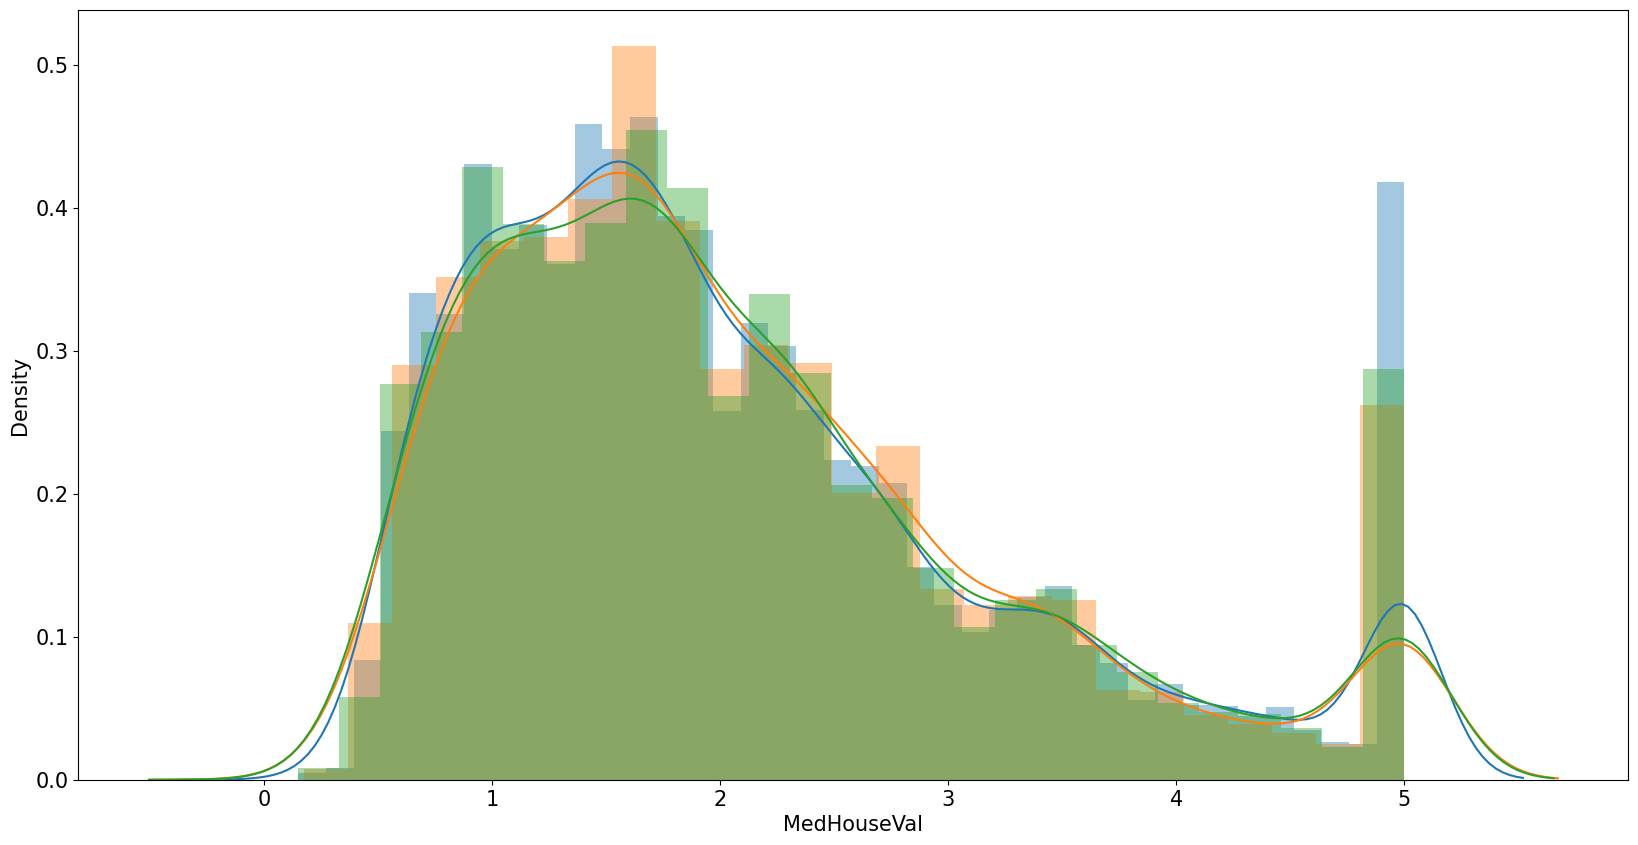

In [43]:
sns.distplot(X_train[LABEL])
sns.distplot(X_val[LABEL])
sns.distplot(test_data[LABEL])

# Baselines

In [44]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20)
rf.fit(X_train[FEATURES], X_train[LABEL])

RandomForestRegressor(max_depth=20)

In [45]:
rf_preds = rf.predict(test_data[FEATURES])
rf_rms = mean_squared_error(test_data[LABEL], rf_preds, squared=False)
print(rf_rms)

0.5111468321095857


## CatBoost

In [46]:
catb_train_dataset = cb.Pool(X_train[FEATURES], X_train[LABEL]) 
catb_val_dataset = cb.Pool(X_val[FEATURES], X_val[LABEL]) 
catb_test_dataset = cb.Pool(test_data[FEATURES], test_data[LABEL])

In [88]:
tuned_catb = cb.CatBoostRegressor()
tuned_catb.fit(catb_train_dataset, eval_set=catb_val_dataset, early_stopping_rounds=50)

Learning rate set to 0.076361
0:	learn: 1.1095583	test: 1.0881120	best: 1.0881120 (0)	total: 12.5ms	remaining: 12.5s
1:	learn: 1.0665468	test: 1.0453537	best: 1.0453537 (1)	total: 14.4ms	remaining: 7.19s
2:	learn: 1.0256526	test: 1.0062932	best: 1.0062932 (2)	total: 16.9ms	remaining: 5.61s
3:	learn: 0.9892363	test: 0.9709483	best: 0.9709483 (3)	total: 18.4ms	remaining: 4.58s
4:	learn: 0.9547325	test: 0.9376612	best: 0.9376612 (4)	total: 19.9ms	remaining: 3.96s
5:	learn: 0.9241432	test: 0.9081350	best: 0.9081350 (5)	total: 22.5ms	remaining: 3.72s
6:	learn: 0.8956798	test: 0.8803798	best: 0.8803798 (6)	total: 25ms	remaining: 3.54s
7:	learn: 0.8700884	test: 0.8555606	best: 0.8555606 (7)	total: 26.8ms	remaining: 3.32s
8:	learn: 0.8476829	test: 0.8335607	best: 0.8335607 (8)	total: 28.3ms	remaining: 3.12s
9:	learn: 0.8265173	test: 0.8135861	best: 0.8135861 (9)	total: 29.9ms	remaining: 2.96s
10:	learn: 0.8076136	test: 0.7953894	best: 0.7953894 (10)	total: 31.4ms	remaining: 2.83s
11:	learn: 0.

In [89]:
catb_preds = tuned_catb.predict(catb_test_dataset)

In [90]:
catb_rms = mean_squared_error(test_data[LABEL], catb_preds, squared=False)

## Modelling Prep

In [50]:
# To TF Dataset
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL, shuffle=True)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

/Users/antonsruberts/personal/TabTransformerTF/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/Users/antonsruberts/personal/TabTransformerTF/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/Users/antonsruberts/personal/TabTransformerTF/tabtransformertf/utils/preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


# FTTransformer

## FT Transformer - Linear Numerical Encoding

In [75]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = [],
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data =None, # No categorical data
    y = None,
    numerical_embedding_type='linear',
    embedding_dim=64,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 1000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/1000
26/26 [==============================] - 10s 230ms/step - loss: 1.2817 - output_loss: 1.2817 - output_rmse: 1.1321 - val_loss: 0.7904 - val_output_loss: 0.7904 - val_output_rmse: 0.8890
Epoch 2/1000
26/26 [==============================] - 6s 212ms/step - loss: 0.7574 - output_loss: 0.7574 - output_rmse: 0.8703 - val_loss: 0.6370 - val_output_loss: 0.6370 - val_output_rmse: 0.7981
Epoch 3/1000
26/26 [==============================] - 5s 190ms/step - loss: 0.6220 - output_loss: 0.6220 - output_rmse: 0.7887 - val_loss: 0.5082 - val_output_loss: 0.5082 - val_output_rmse: 0.7129
Epoch 4/1000
26/26 [==============================] - 5s 192ms/step - loss: 0.5493 - output_loss: 0.5493 - output_rmse: 0.7412 - val_loss: 0.4677 - val_output_loss: 0.4677 - val_output_rmse: 0.6839
Epoch 5/1000
26/26 [==============================] - 5s 205ms/step - loss: 0.5040 - output_loss: 0.5040 - output_rmse: 0.7099 - val_loss: 0.4803 - val_output_loss: 0.4803 - val_output_rmse: 0.6931
Epoch 6/1

## FT Transformer - Periodic Numerical Encoding

In [70]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = [],
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = None,
    y = None,
    numerical_embedding_type='periodic',
    numerical_bins=128,
    embedding_dim=64,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 1000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/1000
26/26 [==============================] - 11s 259ms/step - loss: 1.2407 - output_loss: 1.2407 - output_rmse: 1.1139 - val_loss: 0.6024 - val_output_loss: 0.6024 - val_output_rmse: 0.7761
Epoch 2/1000
26/26 [==============================] - 6s 245ms/step - loss: 0.5353 - output_loss: 0.5353 - output_rmse: 0.7316 - val_loss: 0.4126 - val_output_loss: 0.4126 - val_output_rmse: 0.6424
Epoch 3/1000
26/26 [==============================] - 6s 226ms/step - loss: 0.4323 - output_loss: 0.4323 - output_rmse: 0.6575 - val_loss: 0.3607 - val_output_loss: 0.3607 - val_output_rmse: 0.6006
Epoch 4/1000
26/26 [==============================] - 6s 238ms/step - loss: 0.3879 - output_loss: 0.3879 - output_rmse: 0.6228 - val_loss: 0.3430 - val_output_loss: 0.3430 - val_output_rmse: 0.5857
Epoch 5/1000
26/26 [==============================] - 6s 241ms/step - loss: 0.3541 - output_loss: 0.3541 - output_rmse: 0.5951 - val_loss: 0.3129 - val_output_loss: 0.3129 - val_output_rmse: 0.5594
Epoch 6/1

## FT Transformer - PLE Quantile

In [55]:
ft_pleq_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = [],
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = None,
    y = None,
    numerical_embedding_type='ple',
    numerical_bins=128,
    embedding_dim=64,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass the encoder to the model
ft_pleq_transformer = FTTransformer(
    encoder=ft_pleq_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 1000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_pleq_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

ft_pleq_history = ft_pleq_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/1000
26/26 [==============================] - 191s 3s/step - loss: 1.2836 - output_loss: 1.2836 - output_rmse: 1.1329 - val_loss: 0.4857 - val_output_loss: 0.4857 - val_output_rmse: 0.6969
Epoch 2/1000
26/26 [==============================] - 8s 289ms/step - loss: 0.4944 - output_loss: 0.4944 - output_rmse: 0.7032 - val_loss: 0.3911 - val_output_loss: 0.3911 - val_output_rmse: 0.6254
Epoch 3/1000
26/26 [==============================] - 7s 284ms/step - loss: 0.3846 - output_loss: 0.3846 - output_rmse: 0.6202 - val_loss: 0.3391 - val_output_loss: 0.3391 - val_output_rmse: 0.5823
Epoch 4/1000
26/26 [==============================] - 7s 272ms/step - loss: 0.3544 - output_loss: 0.3544 - output_rmse: 0.5953 - val_loss: 0.3212 - val_output_loss: 0.3212 - val_output_rmse: 0.5668
Epoch 5/1000
26/26 [==============================] - 7s 272ms/step - loss: 0.3272 - output_loss: 0.3272 - output_rmse: 0.5720 - val_loss: 0.2962 - val_output_loss: 0.2962 - val_output_rmse: 0.5443
Epoch 6/100

## FT Transformer - PLE Target

In [65]:
ft_plet_encoder = FTTransformerEncoder(
   numerical_features = NUMERIC_FEATURES,
    categorical_features = [],
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = None,
    y = X_train[LABEL].values,
    task='regression',
    numerical_embedding_type='ple',
    numerical_bins=128,
    embedding_dim=64,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    ple_tree_params = {
        "min_samples_leaf": 20,
    },
    explainable=True
)


# Pass th encoder to the model
ft_plet_transformer = FTTransformer(
    encoder=ft_plet_encoder,
    out_dim=1,
    out_activation=None,
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 1000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_plet_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

ft_plet_history = ft_plet_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/1000
26/26 [==============================] - 298s 4s/step - loss: 1.3294 - output_loss: 1.3294 - output_rmse: 1.1530 - val_loss: 0.6608 - val_output_loss: 0.6608 - val_output_rmse: 0.8129
Epoch 2/1000
26/26 [==============================] - 9s 303ms/step - loss: 0.5900 - output_loss: 0.5900 - output_rmse: 0.7681 - val_loss: 0.4128 - val_output_loss: 0.4128 - val_output_rmse: 0.6425
Epoch 3/1000
26/26 [==============================] - 8s 288ms/step - loss: 0.4200 - output_loss: 0.4200 - output_rmse: 0.6481 - val_loss: 0.3458 - val_output_loss: 0.3458 - val_output_rmse: 0.5881
Epoch 4/1000
26/26 [==============================] - 8s 297ms/step - loss: 0.3787 - output_loss: 0.3787 - output_rmse: 0.6154 - val_loss: 0.3258 - val_output_loss: 0.3258 - val_output_rmse: 0.5708
Epoch 5/1000
26/26 [==============================] - 7s 283ms/step - loss: 0.3394 - output_loss: 0.3394 - output_rmse: 0.5826 - val_loss: 0.3331 - val_output_loss: 0.3331 - val_output_rmse: 0.5772
Epoch 6/100

## Compare

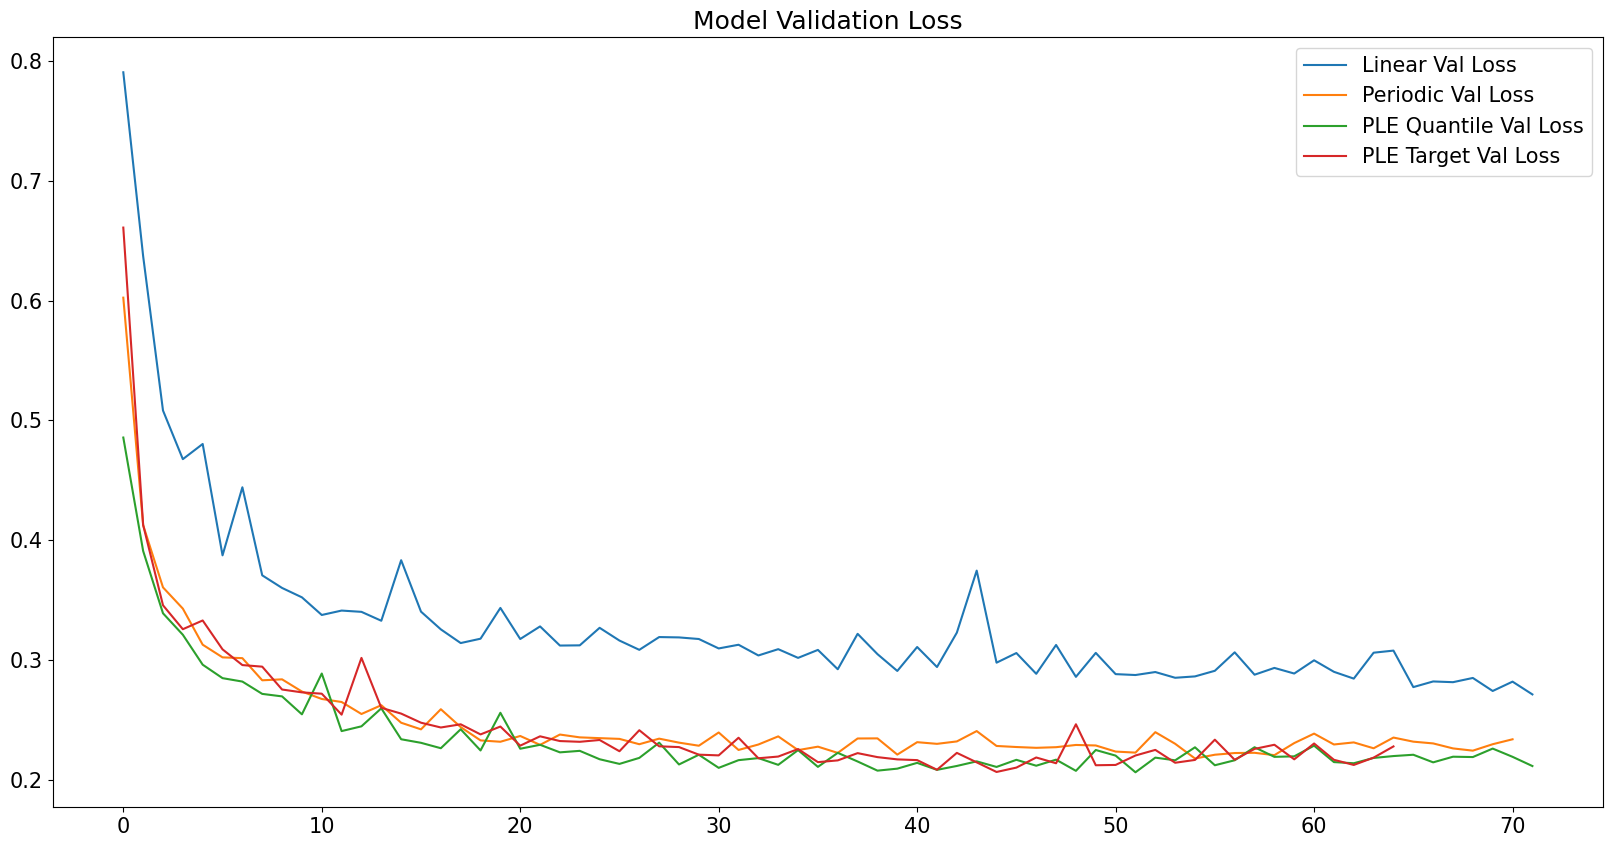

In [102]:
plt.plot(ft_linear_history.history['val_loss'][:72], label='Linear Val Loss')
plt.plot(ft_periodic_history.history['val_loss'][:100], label='Periodic Val Loss')
plt.plot(ft_pleq_history.history['val_loss'][:100], label='PLE Quantile Val Loss')
plt.plot(ft_plet_history.history['val_loss'][:100], label='PLE Target Val Loss')

plt.title('Model Validation Loss')
plt.legend()
plt.show()

In [92]:
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel()., squared=False)

pleq_test_preds = ft_pleq_transformer.predict(test_dataset)
pleq_rms = mean_squared_error(test_data[LABEL], pleq_test_preds['output'].ravel(), squared=False)

plet_test_preds = ft_plet_transformer.predict(test_dataset)
plet_rms = mean_squared_error(test_data[LABEL], plet_test_preds['output'].ravel(), squared=False)

In [108]:
print("-" * 28 + " FT Transformer " + "-" * 27)
print("Linear Encoding RMSE:", linear_rms.round(4))
print("Periodic Encoding RMSE:", periodic_rms.round(4))
print("PLE Encoding with Qantile Binning RMSE:", pleq_rms.round(4))
print("PLE Encoding with Target Binning RMSE:", plet_rms.round(4))
print("")
print("-" * 30 + " Baselines " + "-" * 30)
print("Random Forest RMSE:", rf_rms.round(4))
print("Catboost RMSE:", catb_rms.round(4))


---------------------------- FT Transformer ---------------------------
Linear Encoding RMSE: 0.5153
Periodic Encoding RMSE: 0.4848
PLE Encoding with Qantile Binning RMSE: 0.4553
PLE Encoding with Target Binning RMSE: 0.4578

------------------------------ Baselines ------------------------------
Random Forest RMSE: 0.5111
Catboost RMSE: 0.4487


## Tuning

In [66]:
# import optuna
# import gc

# def objective(trial):
#     ft_encoder = FTTransformerEncoder(
#         numerical_features = NUMERIC_FEATURES,
#         categorical_features = [],
#         numerical_data = X_train[NUMERIC_FEATURES].values,
#         categorical_data = None,
#         y = X_train[LABEL].values,
#         task='regression',
#         numerical_embedding_type= 'ple',
#         numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
#         embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
#         depth=trial.suggest_int('depth', 1, 6),
#         heads=trial.suggest_int('heads', 2, 8),
#         attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
#         ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
#         explainable=True
#     )


#     # Pass th encoder to the model
#     ft_transformer = FTTransformer(
#         encoder=ft_encoder,
#         out_dim=1,
#         out_activation=housing_act
#     )

#     LEARNING_RATE = 0.001
#     WEIGHT_DECAY = 0.00001
#     NUM_EPOCHS = 1000

#     optimizer = tfa.optimizers.AdamW(
#             learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
#         )

#     ft_transformer.compile(
#         optimizer = optimizer,
#         loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
#         metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
#     )

#     early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
#     callback_list = [early]

#     ft_history = ft_transformer.fit(
#         train_dataset, 
#         epochs=NUM_EPOCHS, 
#         validation_data=val_dataset,
#         callbacks=callback_list
#     ) 
    
#     preds = ft_transformer.predict(test_dataset)
    
#     rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel().clip(0, 5),squared=False)
#     gc.collect()
    
#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)